# 🤗 Diffusers를 활용하여 Diffusion Models 학습해보기

#### 학습 목표

> Diffusion Model을 학습시켜보며 Diffusion Model의 구조와 학습 방법을 이해한다.

**Content**
1. HuggingFace framework 소개
2. Config 설정하기
3. 데이터셋 불러오기
4. Diffusion Model의 구조와 목적함수
5. Noise scheduler 정의하기
6. Diffusion Model 학습하기
7. 결론

## 1. HuggingFace framework 소개

> [🤗 Datasets](https://huggingface.co/docs/datasets/index): 다양한 Datasets를 쉽게 다운받을 수 있는 library.
>
> [🤗 Accelerate](https://huggingface.co/docs/accelerate/index): Multi-GPU, FP16, Gradient accumulation, logging등을 쉽게 해주는 library.
>
> [🤗 Diffusers](https://huggingface.co/docs/diffusers/index): 다양한 diffusion model들을 활용할 수 있는 library.


In [ ]:
%%capture
!pip install diffusers[training]==0.11.1

## 2. Config 설정하기

> 학습에 필요한 대부분의 configuration들을 아주 간단하게 선언하고 사용할 수 있다.
>
> 대부분의 주요한 hyper-parameter들을 정의할 수 있기 때문에 다양한 실험 셋팅에 대해서 쉽게 바꿔가면서 실험할 수 있다.
>
> `number of epochs`, `batch size`, `learning rate` 등의 다양한 hyperparameter를 바꿔가며 실험해보자.

In [ ]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 128  # 이미지 해상도
    train_batch_size = 16  # 학습 배치 사이즈
    eval_batch_size = 16  # 평가(생성) 배치 사이즈
    num_epochs = 10  # 학습 에포크 수. 50이면 꽤 괜찮은 이미지가 생성되지만 1시간 정도 소요됨.
    gradient_accumulation_steps = 1  # 배치가 한 번에 gpu에 들어가지 않을 때 사용할 수 있는 gradient accumulation.
    # 여러 번 반복해서 gradient만 따로 쌓아둔 다음 원하는 배치 사이즈 만큼 되었을 때, gradient descent(step)을 진행함.
    learning_rate = 1e-4  # 학습에 사용되는 learning rate
    lr_warmup_steps = 100  # 학습 초기 learning rate을 작게 시작해야 좋다는 실험적 테크닉 warmup.
    # num_epochs가 50일 때는 비례하여 500으로 변경해주면 됨.
    save_image_epochs = 10  # 이미지를 저장하는 주기 (단위: epoch)
    save_model_epochs = 10  # 모델을 저장하는 주기 (단위: epoch)
    mixed_precision = 'fp16'  # `no`: float32, `fp16`: automatic mixed precision로 VRAM 사용량에 큰 차이가 있음.
    output_dir = 'ddpm-butterflies-128'  # 프로젝트 디렉토리 이름
    push_to_hub = False  # hugging face hub에 업로드 하는지에 대한 여부
    hub_private_repo = False  # hugging face hub의 private 여부
    overwrite_output_dir = True  # output directory가 존재할 때, 덮어쓸지 설정
    seed = 0  # 학습 전체 불확실성을 결정하는 시드

config = TrainingConfig()

## 3. 데이터셋 불러오기

> [🤗 Datasets](https://github.com/huggingface/datasets) library를 통해서 `smithsonian_butterflies` 데이터셋을 다운받아 보도록 하자.
>
> Huggingface datasets에서는 다운로드도 지원하지만 데이터셋을 remote로 그때그때 받아서 학습하는 것 역시 지원한다.
>
> Remote로 받아서 학습하는 것은 데이터를 불러오는데 오래 걸리므로, 일반적으로 한 번에 다운받은 후 다운받은 데이터를 활용한다.

In [ ]:
from datasets import load_dataset

config.dataset_name = "huggan/smithsonian_butterflies_subset"
dataset = load_dataset(config.dataset_name, split="train")

# 이 외에도 이미지 생성 모델을 위한 다양한 데이터셋이 존재하므로 다음 링크를 참고하자.
# https://hf.co/huggan/

# 다른 데이터셋 예시 (Oxford Flowers 102)
# config.dataset_name = "huggan/flowers-102-categories"
# dataset = load_dataset(config.dataset_name, split="train")

# 또는 개인이 가지고 있는 local 데이터셋을 활용할 수도 있다. `imagefolder`를 활용하면 내 데이터셋을 활용할 수 있다.
# config.dataset_name = "imagefolder"
# dataset = load_dataset(config.dataset_name, data_dir="path/to/folder")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/huggan___parquet/huggan--smithsonian_butterflies_subset-7665b1021a37404c/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7. Subsequent calls will reuse this data.


> 불러온 데이터셋의 형식에 대해 알아보자.
>
> 그리고, 본 데이터셋에 있는 다양한 정보 중 `image`를 한 번 뽑아보자.

In [ ]:
dataset

Dataset({
    features: ['image_url', 'image_alt', 'id', 'name', 'scientific_name', 'gender', 'taxonomy', 'region', 'locality', 'date', 'usnm_no', 'guid', 'edan_url', 'source', 'stage', 'image', 'image_hash', 'sim_score'],
    num_rows: 1000
})

> [`Image`](https://huggingface.co/docs/datasets/image_process#image-datasets) 는 PIL.Image 형태로 불러와집니다.
> 확인해봅시다.

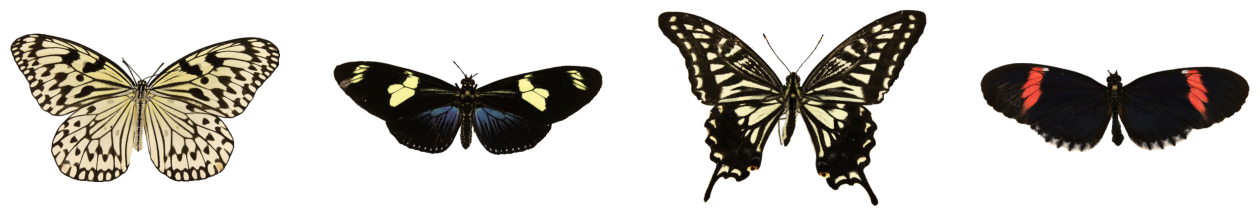

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["image"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

> 이미지 데이터를 이제 전처리 해줘야 한다. 이미지 생성 모델에서 주로 활용되는 전처리를 알아보자.
>
> * `Resize`: 앞에서 정의한 `config.image_size`를 받아서 해당 크기로 resize 한다.
> * `RandomHorizontalFlip`: 대부분의 이미지는 좌우를 바꾸어도 의미론적 손상이 없기 때문에 `RandomHorizontalFlip`은 효율적으로 데이터를 증강시킬 수 있는 방법 중 하나로 자주 쓰인다.
> * `ToTensor`: `PIL.Image`의 구조인 이미지를 PyTorch에 맞는 형식인 `torch.Tensor`의 구조로 바꾸어준다.
> * `Normalize`: 이미지의 평균을 0으로, 분산을 1로 만들어주기 위해서 사용된다.


In [ ]:
from torchvision import transforms

# 위에서 언급한 전처리를 순차적으로 적용하기 위해 `transforms.Compose`를 활용한다.
preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

> 정의된 전처리 함수를 데이터셋에 적용해보자.
>
> 🤗 Datasets에서 제공하는 `set_transform()` method를 이용하여 전처리 함수를 적용할 수 있다.

In [ ]:
def transform(examples):
    # example에 있는 다양한 정보 중 `image`를 전처리해서 가져옴
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    # 돌려줄 때에는 마찬가지로 dictionary 형식으로 전달해준다
    return {"images": images}

dataset.set_transform(transform)

> 이미지가 어떻게 전처리 되었는지 확인해보자.
>
> 이제 앞으로 `dataset`에서 부르는 이미지는 항상 아래와 같이 전처리 되어 나오게 된다.

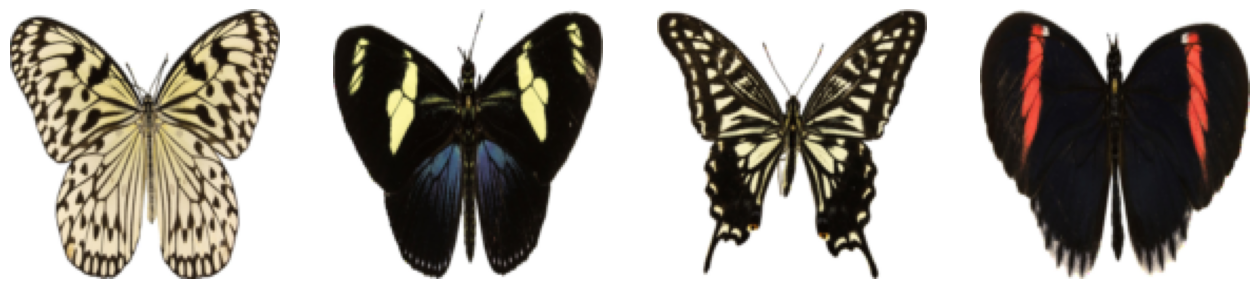

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["images"]):
    axs[i].imshow(image.permute(1, 2, 0).numpy() / 2 + 0.5)
    axs[i].set_axis_off()
fig.show()

> (B, C, H, W)의 mini-batch를 구성하기 위해서는 위와 같은 전처리를 이용하여 가로(W), 세로(H)의 길이를 맞춰주어야 한다.
>
> 이제, 이미지가 전처리를 통해 모두 같은 크기를 가지게 되었으며, mini-batch 학습이 가능해진 것을 확인할 수 있다.

> 다음과 같이 `DataLoader`를 이용하여 전처리된 이미지를 배치 사이즈로 묶어서 (B, C, H, W)로 호출 할 수 있다.


In [ ]:
import torch

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

## 4. Diffusion Model의 구조와 목적함수

> Diffusion models는 복잡한 수식을 통해서 전개된 생성 모델이지만 간단하게 설명하면, 아래 그림과 같이 결국 image와 같은 크기의 Gaussian noise부터 시작하여 점차 noise를 제거해 나가며 이미지를 생성하는 모델이다.
>
> Diffusion models의 학습은 이미지에 임의의 noise를 끼웠다가 해당 noise를 제거하라는 목적 함수를 통해 진행된다.
>
> 본 실습에서는 이 과정을 Diffusers framework를 이용하여 간단하게 학습해 볼 것이다.

<p align="center">
    <img src="https://user-images.githubusercontent.com/10695622/174349667-04e9e485-793b-429a-affe-096e8199ad5b.png" width="800"/>
    <br>
    <em> Figure from DDPM paper (https://arxiv.org/abs/2006.11239). </em>
<p>

> 우리가 최종적으로 학습할 것은 $p_{\theta}(x_{t-1}|x_{t})$이며 학습 알고리즘은 다음과 같다.
>
> 1. Training set에서 이미지를 한 장 가져온다.
> 2. 임의의 noise를 $t$번 뿌려서 $x_t$를 만들어 낸다.
> 3. 우리의 diffusion model $\theta$에 $x_t$와 $t$를 입력으로 넣어준다.
> 4. 모델이 예측한 noise와 실제 뿌린 noise와의 차이를 계산하여 loss를 계산하고 모델을 학습시킨다.
> 5. 1-4를 모델이 수렴할 때까지 반복한다.


> 대부분의 diffusion models은 입력과 출력의 H, W, C가 동일하다는 특징을 고려하여 [U-Net](https://arxiv.org/abs/1505.04597)의 구조를 가진다.

![](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/unet-model.png)

> Downsample block과 Upsample block은 residual connection을 가지는 ResNet의 구조를 가지며, 몇몇 layers에는 self-attention이 포함되어 있다.
>
> U-Net의 구조 내에서, 학습하는 데이터의 난이도에 따라서 아래와 같은 hyper-parameter를 변경하여 최적의 모델 구조를 찾는다.
>
> * `type of layers`: layer의 종류 (Up, Down 등)
> * `in_channels`: 입력 채널 수 (RGB이므로 보통 3)
> * `out_channels`: 출력 채널 수 (마찬가지로 RGB이므로 보통 3)
> * `layers_per_block`: 각 block 별 layer의 수
> * `block_out_channels`: 각 block의 입출력 채널 수 (embedding의 차원을 결정함)

In [ ]:
from diffusers import UNet2DModel


model = UNet2DModel(
    sample_size=config.image_size,  # 이미지의 사이즈 (해상도)
    in_channels=3,  # 입력 채널 수 (RGB이므로 보통 3)
    out_channels=3,  # 출력 채널 수 (마찬가지로 RGB이므로 보통 3)
    layers_per_block=2,  # 각 U-Net 블럭에 들어갈 layer의 수
    block_out_channels=(128, 128, 256, 256, 512, 512),  # 각 block의 입출력 채널 수 (embedding의 차원을 결정)
    down_block_types=(
        "DownBlock2D",  # 일반적인 ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # ResNet downsampling block에 spatial Self-attention layer가 추가됨
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # 일반적인 ResNet upsampling block
        "AttnUpBlock2D",  # ResNet upsampling block에 spatial Self-attention layer가 추가됨
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D"
      ),
)

> 정의한 모델로 이미지를 통과시켜보고 같은 크기의 출력이 나오는지 확인해보자.

In [ ]:
sample_image = dataset[0]['images'].unsqueeze(0)
print('Input shape:', sample_image.shape)

Input shape: torch.Size([1, 3, 128, 128])


In [ ]:
print('Output shape:', model(sample_image, timestep=0).sample.shape)

Output shape: torch.Size([1, 3, 128, 128])


> 그런데 우리의 U-Net 모델은 noisy한 입력 $x_t$를 받으며 이 $x_t$가 얼마나 noisy한지 힌트를 얻기 위해서 timestep $t$를 추가로 condition으로 받는다.
>
> $t$는 보통 U-Net에 condition의 형태로 주입되는데, 이 과정에서 $t$는 하나의 scalar로 입력으로 받기보다는 transformers에서 자주 쓰이는 [sinusoidal positional embedding](https://arxiv.org/abs/1706.03762)을 진행하여 high dimension으로 만들어 준 후 입력으로 받는다.
>
> $t$를 conditioning 하는 방법은 일반적으로 AdaGN, Cross-Attention을 활용하는데 자세한 내용은 다음 논문을 참고하도록 하자 [ADM](https://arxiv.org/abs/2105.05233)


## 5. Noise scheduler 정의하기

> 이제 우리는 noise를 추가하는 과정을 구현해보도록 하자.
>
> Noise를 timestep $t$만큼 추가하는데, 그 정도를 조절하는 과정을 우리는 **noise scheduling**이라고 하며, 다양한 noise scheduling 방식은 Diffusers library내에 모두 구현되어 있다.
>
> 우리는 그 중 DDPM 논문에서 제안된 scheduler인 `DDPMScheduler`라고 불리는 Diffusers의 class를 써보도록 하자.


In [ ]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000  # 학습 시 timesteps을 몇 단계로 나눌 지 결정.
)

> 이제 Diffusers에서 제공하는 함수인 `noise_scheduler.add_noise`를 이용하여 이미지를 noising 해보자.

Original Image


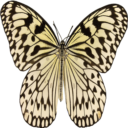

Noised Image


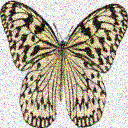

In [ ]:
import torch
from PIL import Image
import torchvision

noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([100])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

print('Original Image')
display(torchvision.transforms.ToPILImage()(sample_image[0].clamp(-1, 1)/2+.5))
print('Noised Image')
display(Image.fromarray(((noisy_image.permute(0, 2, 3, 1).clamp(-1, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0]))

> 다양한 timesteps에 대해서 noise를 추가하면 다음과 같다.

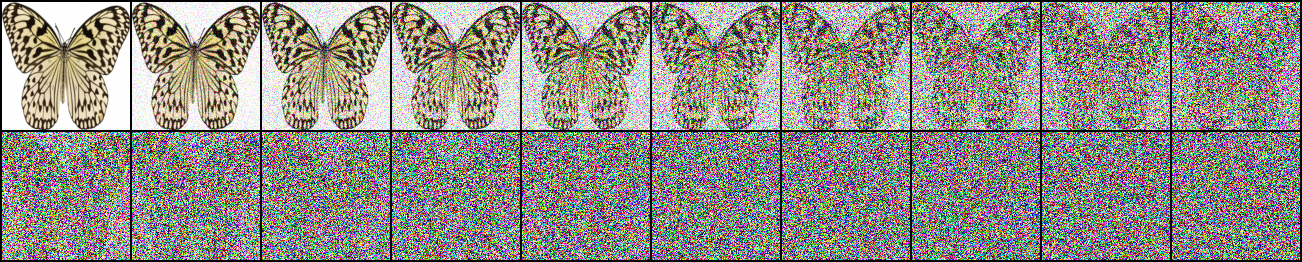

In [ ]:
import torchvision
noisy_images = [noise_scheduler.add_noise(sample_image, torch.randn(sample_image.shape), t) for t in [torch.LongTensor([i]) for i in range(0, 1000, 50)]]
noisy_images = torchvision.transforms.ToPILImage()(torchvision.utils.make_grid((torch.cat(noisy_images) / 2 + 0.5).clamp(0, 1), nrow=10))
display(noisy_images)

> DDPM의 목적은 `noise_scheduler.add_noise`에서 사용되었던 `noise`를 예측하는 것이다.
>
> 즉, U-Net의 입력으로는 noisy한 이미지가 들어가고, 출력으로는 어떤 noise가 추가되었는지 출력하여 맞춰야 하는 상황이다.
>
> 이를 학습하기 위해서, `noisy_image`, `timesteps`를 앞서 정의한 U-Net의 입력으로 받아보고, 출력으로 `noise`가 나오도록 MSE loss를 걸어 학습하는 예시 코드를 짜면 다음과 같다.

In [ ]:
import torch.nn.functional as F

noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)
print(loss)

tensor(1.1819, grad_fn=<MseLossBackward0>)


## 6. Diffusion Model 학습하기

> 이제 모든 이론적인 준비가 끝났다.
>
> AdamW optimizer를 이용하여 학습을 진행해보자.
>
> > AdamW: [Paper](https://arxiv.org/abs/1711.05101), [blog](https://hiddenbeginner.github.io/deeplearning/paperreview/2019/12/29/paper_review_AdamW.html)

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

> Learning rate scheduling으로는 warmup start와 더불어 cosine learning rate schedule을 사용할 것이다.


In [ ]:
from diffusers.optimization import get_cosine_schedule_with_warmup

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

> 평가를 위해서는 이미지를 뽑아봐야 하는데, 1000부터 0까지 denoising하는 pipeline 역시 `diffusers`에 구현되어 있다.
>
> 우리가 뽑은 이미지를 grid의 형태로 만들어서 `test_dir`에 저장해보자.
>
> `DDPMPipeline`을 사용해서 이미지를 sample 하는 코드는 다음과 같다.

In [ ]:
from diffusers import DDPMPipeline

import math

def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i%cols*w, i//cols*h))
    return grid

def evaluate(config, epoch, pipeline):
    images = pipeline(
        batch_size = config.eval_batch_size,
        generator=torch.manual_seed(config.seed),
        # 따로 noise를 정의하지 않으면 pipeline 내에서 Gaussian Distribution으로부터 initial noise를 정의해준다.
        # 정의하는 noise를 고정하고 싶으면 noise를 직접 뽑아서 줘도 되고, 위 generator 함수를 시드를 고정해서 줘도 된다.
    ).images

    # 4 by 4로 그리드를 그려보자.
    image_grid = make_grid(images, rows=4, cols=4)

    # 이미지를 저장하자.
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

> 이제 전체 `train_loop`를 짜보도록 하자.
>
> 🤗 Accelerate을 이용하여 기타 학습 환경 설정을 하도록 하자.
> 🤗 Accelerate library는 다음과 같은 작업이 가능하다:
>
> - Logging을 위한 TensorBoard
> - 큰 batch_size를 작은 GPU에서 학습시키기 위한 Gradient accumulation
> - 효율적인 GPU 메모리 사용을 위한 mixed precision
> - Multi-GPUs or TPU를 이용한 학습


In [ ]:
from accelerate import Accelerator
from huggingface_hub import HfFolder, Repository, whoami

from tqdm.auto import tqdm
from pathlib import Path
import os

def get_full_repo_name(model_id: str, organization: str = None, token: str = None):
    if token is None:
        token = HfFolder.get_token()
    if organization is None:
        username = whoami(token)["name"]
        return f"{username}/{model_id}"
    else:
        return f"{organization}/{model_id}"

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Accelerator 선언
    # tensorboard를 통한 logging도 지원한다.
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs")
    )
    if accelerator.is_main_process:
        if config.push_to_hub:
            repo_name = get_full_repo_name(Path(config.output_dir).name)
            repo = Repository(config.output_dir, clone_from=repo_name)
        elif config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        accelerator.init_trackers("train_example")

    # model, optimizer, train_dataloader, lr_scheduler을 accelerator.prepare 함수에 통과시킨다.
    # Multi-gpu, mixed precision 등에 대응할 수 있도록 만들어 줌.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

    # 이제 모델을 학습시켜보자.
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch['images']
            # 이미지에 추가할 noise를 정의
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]

            # noise를 추가하는 정도인 timestep을 정의
            timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()

            # Noise를 timestep에 따라서 추가한다. (forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                # 모델을 통해서 noisy image와 timestep으로부터 추가된 noise를 예측 및 학습
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # 학습이 끝난 후, 이미지를 직접 생성해보며 얼마나 잘 학습되었는지 정성적으로 확인할 수 있다.
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.push_to_hub:
                    repo.push_to_hub(commit_message=f"Epoch {epoch}", blocking=True)
                else:
                    pipeline.save_pretrained(config.output_dir)

> Colab에서 학습을 진행하기 위해서는 `notebook_launcher`를 사용해야 한다.
>
> 일반 서버에서 학습을 진행할 때에는 `python ...` 또는 `accelrate ...` 으로 학습을 진행할 수 있다.

In [ ]:
from accelerate import notebook_launcher
args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

notebook_launcher(train_loop, args, num_processes=1)

> 학습 도중 저장된 샘플을 확인해보면 다음과 같다.

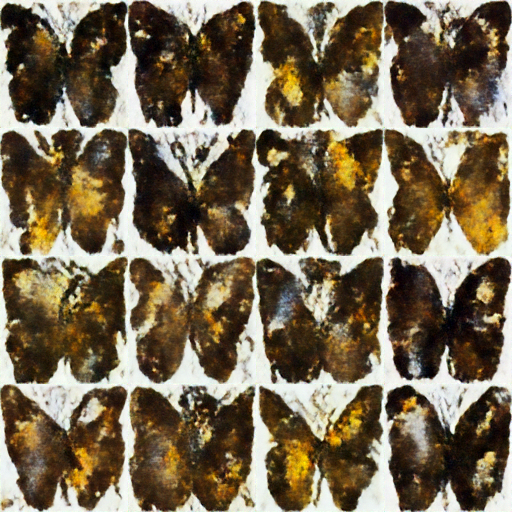

In [ ]:
import glob

sample_images = sorted(glob.glob(f"{config.output_dir}/samples/*.png"))
Image.open(sample_images[-1])

> 제한된 시간과 제한된 컴퓨팅 파워로 인해 생성된 나비 사진의 퀄리티가 좋지는 않다.
> 하지만 5배만 학습을 길게 하더라도 다음과 같은 퀄리티의 이미지를 얻을 수 있다.
>
> Diffusion model의 학습 경향에 대해 더 공부해보고 싶다면, 앞의 configuration을 바꿔가며 실험해보자.
>
> ![](https://huggingface.co/anton-l/ddpm-butterflies-128/resolve/main/samples/0049.png)
> * 출처: [5배 길게 학습한 실험 Link](https://huggingface.co/anton-l/ddpm-butterflies-128/tree/main)

## 7. 결론

> DDPM을 비롯한 diffusion models은 간단한 학습 loss를 가지고 있음에도, 대규모의 복잡한 데이터도 효과적으로 모델링 할 수 있는 것으로 알려져 있다.
>
> Diffusion models의 이러한 장점을 더욱 살려서, 최근에는 빅테크 기업들이 Stable Diffusion, Imagen, DALL-E 등 diffusion models 구조를 기반으로한 text-to-image model을 만들고 있다.
>
> 다음에는 이러한 DDPM의 이론적 배경을 기반으로 하면서, 대규모 이미지-문자열 쌍으로부터 학습한 모델인 Stable Diffusion에 대해서 알아보도록 하자.
